### Usual suspects

In [2]:
from helper_loader import *

set_logging_level(logging.WARNING)

### Load image and alignment settings

In [3]:
alignment_path = Path(
    "/home/ediun/git/histalign/projects/project_cortical_depth/9f5d5f117d/7b067a31b027506e3b39b5679a5151f9.json"
)
alignment_settings = load_alignment_settings(alignment_path)

In [4]:
image = load_image(alignment_settings.histology_path)

### Load masks and contours

In [5]:
isocortex_volume = load_structure_mask(
    "Isocortex",
    alignment_settings.volume_settings.resolution,
    return_raw_array=False,
)
cortical_structure_volume = load_structure_mask(
    "Primary motor area, Layer 1",
    alignment_settings.volume_settings.resolution,
    return_raw_array=False,
)

isocortex_slice = VolumeSlicer(volume=isocortex_volume).slice(
    alignment_settings.volume_settings
)
cortical_structure_slice = VolumeSlicer(volume=cortical_structure_volume).slice(
    alignment_settings.volume_settings
)

isocortex_contour = compute_largest_contour(isocortex_slice)
cortical_structure_contour = compute_largest_contour(cortical_structure_slice)

### Compute baseline depths of target structure

In [6]:
isocortex_points = np.flipud(np.squeeze(isocortex_contour))
cortical_structure_points = np.flipud(np.squeeze(cortical_structure_contour))

closest_isocortex_points = compute_closest_contour_point(
    cortical_structure_points, isocortex_points
)

baseline_depths = compute_distances_nonisometric_grid(
    cortical_structure_points,
    closest_isocortex_points,
    alignment_settings.volume_settings.resolution,
    alignment_settings.volume_settings.resolution,
)

### Apply reverse registration on contour points

In [7]:
transformation_matrix = get_transformation_matrix_from_q_transform(
    recreate_q_transform_from_alignment(
        isocortex_slice.shape,
        alignment_settings,
        True,
    ),
    True,
)

registered_cortical_structure_points = apply_transformation_matrix_to_contour(
    transformation_matrix,
    cortical_structure_points,
)
registered_closest_isocortex_points = apply_transformation_matrix_to_contour(
    transformation_matrix,
    closest_isocortex_points,
)

### Compute registered depths of target structure

In [8]:
registered_depths = compute_distances_nonisometric_grid(
    registered_cortical_structure_points,
    registered_closest_isocortex_points,
    alignment_settings.volume_settings.resolution
    / alignment_settings.histology_settings.scale_x,
    alignment_settings.volume_settings.resolution
    / alignment_settings.histology_settings.scale_y,
)

### Visualise results

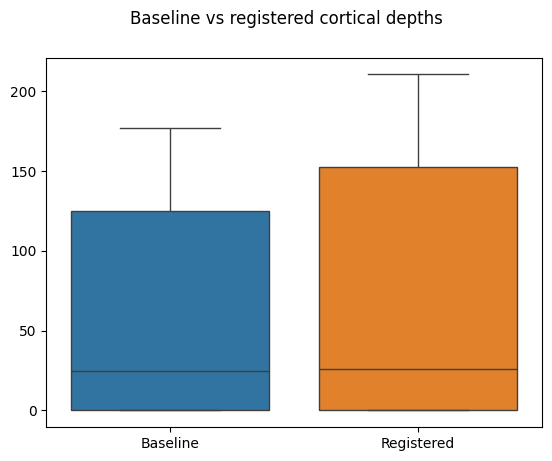

In [9]:
plt.suptitle("Baseline vs registered cortical depths")
sns.boxplot([baseline_depths, registered_depths])
plt.xticks([0, 1], ["Baseline", "Registered"])
plt.show();

In [10]:
nonzero_indices = baseline_depths.nonzero()

clipped_baseline_depths = baseline_depths[nonzero_indices]
clipped_registered_depths = registered_depths[nonzero_indices]

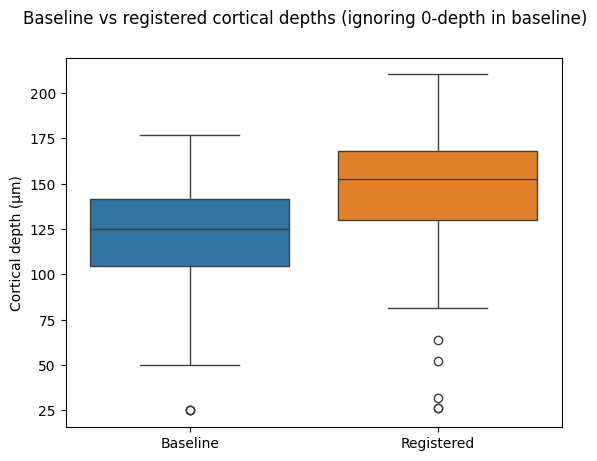

In [11]:
plt.suptitle("Baseline vs registered cortical depths (ignoring 0-depth in baseline)")
plot = sns.boxplot([clipped_baseline_depths, clipped_registered_depths])
plt.xticks([0, 1], ["Baseline", "Registered"])
plot.set_ylabel("Cortical depth (μm)")
plt.show();